In [43]:
# basic imports for modelling notebook
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [44]:
df=pd.read_csv('../data/modelling_4_data.csv')

In [45]:
df.columns

Index(['year', 'month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'date', 'month_sin', 'month_cos', 'arr_flights_ewma', 'arr_del15_ewma',
       'arr_cancelled_ewma', 'arr_diverted_ewma', 'arr_delay_ewma',
       'carrier_ct_ewma', 'weather_ct_ewma', 'nas_ct_ewma', 'security_ct_ewma',
       'late_aircraft_ct_ewma', 'carrier_delay_ewma', 'weather_delay_ewma',
       'nas_delay_ewma', 'security_delay_ewma', 'late_aircraft_delay_ewma',
       'past_years_monthly_ewma', 'is_covid_year'],
      dtype='object')

In [46]:
df

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,nas_ct_ewma,security_ct_ewma,late_aircraft_ct_ewma,carrier_delay_ewma,weather_delay_ewma,nas_delay_ewma,security_delay_ewma,late_aircraft_delay_ewma,past_years_monthly_ewma,is_covid_year
0,2019,1,9E,ABE,40.0,8.0,3.48,0.0,2.18,0.0,...,1.766113,0.000000e+00,2.881582,340.750000,26.937500,46.224609,0.000000,204.533203,NaN,0
1,2020,1,9E,ABE,50.0,6.0,4.88,0.0,0.94,0.0,...,0.213864,0.000000e+00,2.130120,147.069519,8.108139,6.091852,0.000000,137.650277,387.00,1
2,2021,1,9E,ABE,110.0,1.0,0.63,0.0,0.38,0.0,...,0.157476,0.000000e+00,0.748243,61.062772,2.766047,4.832390,0.000000,27.533790,389.00,0
3,2022,1,9E,ABE,119.0,14.0,5.43,1.0,6.83,0.0,...,3.525937,0.000000e+00,2.299265,258.827408,2.174503,96.235067,0.000000,106.932992,210.50,0
4,2023,1,9E,ABE,14.0,1.0,0.00,1.0,0.00,0.0,...,1.509828,1.296875e-02,0.752849,229.284482,9.285838,77.758731,0.390625,33.093488,381.25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178742,2022,11,YV,YUM,2.0,0.0,0.00,0.0,0.00,0.0,...,0.294839,1.831055e-06,2.029243,147.900232,0.280000,28.881659,0.000183,189.779999,551.00,0
178743,2019,12,YV,YUM,59.0,19.0,3.72,0.0,3.77,0.0,...,1.908281,0.000000e+00,3.155937,227.125000,1.875000,55.500000,0.000000,259.921875,NaN,0
178744,2020,12,YV,YUM,30.0,4.0,3.09,0.0,0.00,0.0,...,0.116321,0.000000e+00,0.799789,50.023926,0.522949,3.126953,0.000000,31.874695,1178.00,1
178745,2021,12,YV,YUM,38.0,8.0,3.66,1.0,0.86,0.0,...,1.357770,9.375000e-04,4.632178,138.918969,3.359886,46.409304,0.093750,335.359253,996.50,0


In [47]:
# Step 1: Split train and test
train_val_df = df[df['year'] < 2023].copy()
test_df = df[df['year'] == 2023].copy()

# Step 2: Drop unwanted columns
drop_cols = ['month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'date']
target = 'arr_delay'

# Optional: keep row index for final mapping
train_val_df = train_val_df.reset_index(drop=True)


In [48]:
print(df['arr_delay'].describe())

count    178747.000000
mean       3868.713998
std       11909.596123
min           0.000000
25%         290.000000
50%         903.000000
75%        2552.000000
max      438783.000000
Name: arr_delay, dtype: float64



🌀 Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4113
[LightGBM] [Info] Number of data points in the train set: 26033, number of used features: 20
[LightGBM] [Info] Start training from score 3169.459186
✅ LightGBM MAE: 1735.56
✅ XGBoost MAE: 1737.04

🌀 Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4113
[LightGBM] [Info] Number of data points in the train set: 52062, number of used features: 20
[LightGBM] [Info] Start training from score 4189.506665
✅ LightGBM MAE: 1090.95
✅ XGBoost MAE: 1105.68

🌀 Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

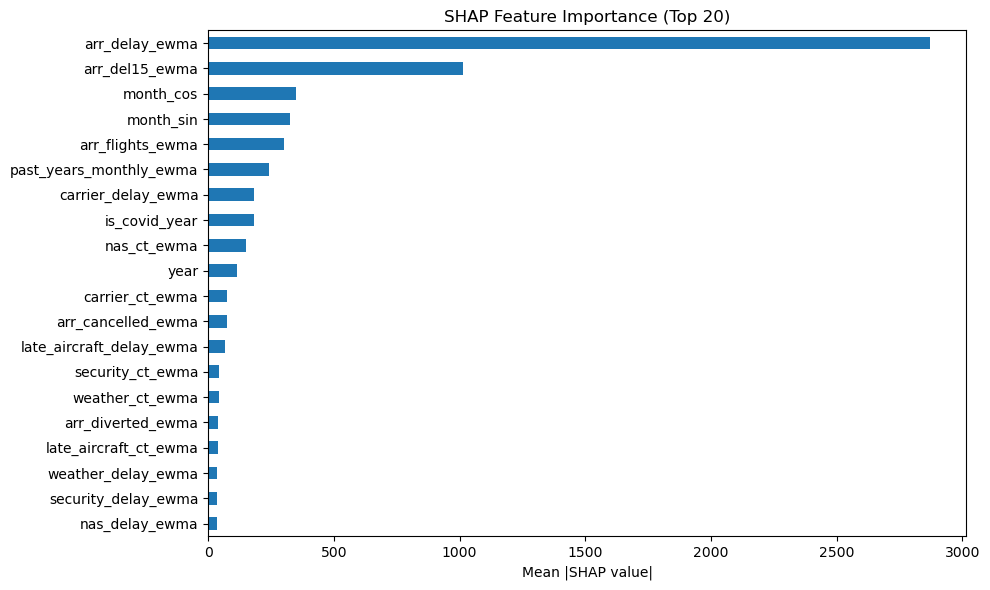


📌 SHAP Waterfall Plot for One Prediction:


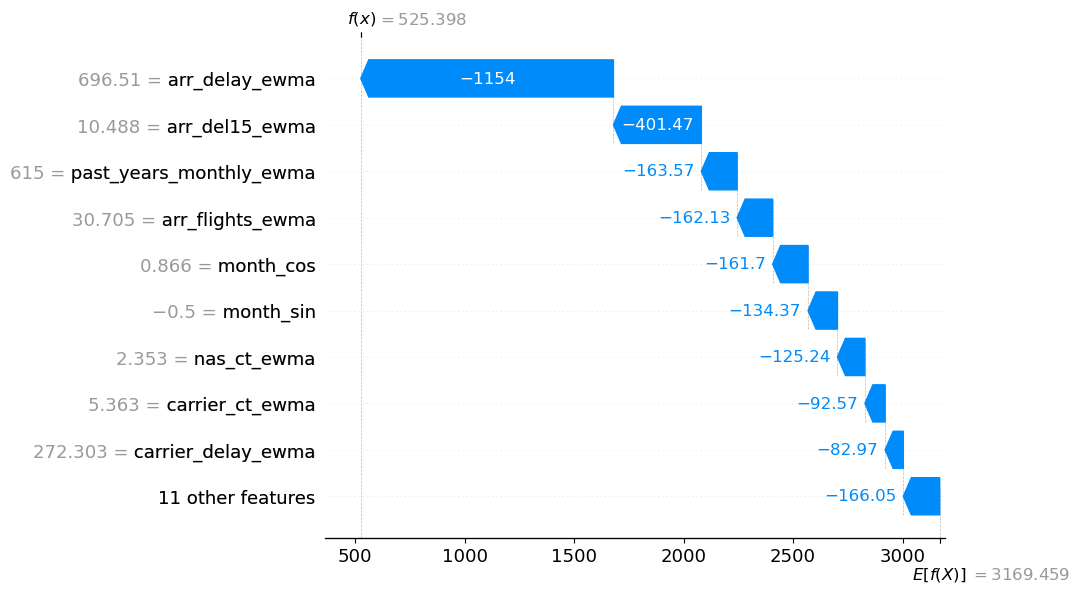


📊 SHAP Summary Plot (Top Features Distribution):


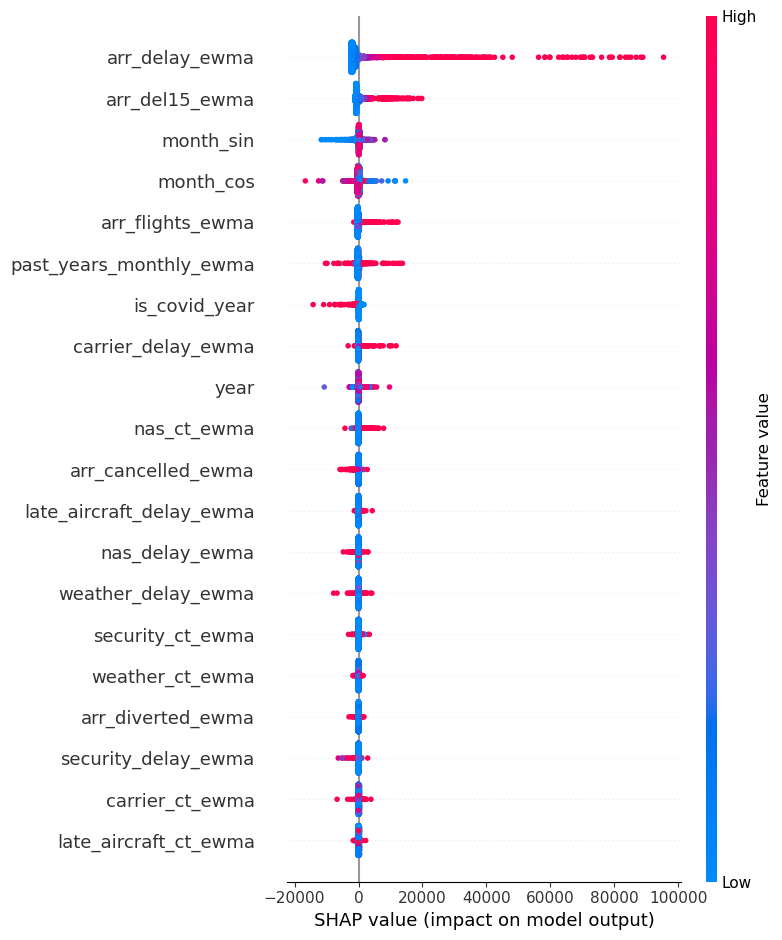

In [49]:
# Step 3: Define features
X = train_val_df.drop(columns=drop_cols + [target])
y = train_val_df[target]

# Step 4: Time-based cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Results storage
model_results = {
    'lgbm': {'maes': []},
    'xgb': {'maes': []}
}
shap_feature_importance_list = []
example_shap_values = None  # For waterfall plot

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\n🌀 Fold {fold+1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # ========== LightGBM ==========
    lgb_model = LGBMRegressor(random_state=42)
    lgb_model.fit(X_train, y_train)
    lgb_preds = lgb_model.predict(X_val)
    lgb_mae = mean_absolute_error(y_val, lgb_preds)
    model_results['lgbm']['maes'].append(lgb_mae)

    # ========== XGBoost ==========
    xgb_model = xgb.XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_val)
    xgb_mae = mean_absolute_error(y_val, xgb_preds)
    model_results['xgb']['maes'].append(xgb_mae)

    # ========== SHAP for LGBM ==========
    # Sample for speed
    X_sample = X_train.sample(n=min(5000, len(X_train)), random_state=42)
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(X_sample)

    # Mean absolute SHAP per feature
    mean_shap_importance = np.abs(shap_values).mean(axis=0)
    shap_feature_importance_list.append(pd.Series(mean_shap_importance, index=X.columns))
    
    # Save one example for waterfall plot
    if example_shap_values is None:
        example_shap_values = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value,
                                               data=X_sample.iloc[0], feature_names=X_sample.columns)

    # ========== Fold Results ==========
    print(f"✅ LightGBM MAE: {lgb_mae:.2f}")
    print(f"✅ XGBoost MAE: {xgb_mae:.2f}")

# ========== Final Results ==========
print("\n📊 Final Cross-Validation Results:")
print(f"LightGBM Mean MAE: {np.mean(model_results['lgbm']['maes']):.2f}")
print(f"XGBoost Mean MAE: {np.mean(model_results['xgb']['maes']):.2f}")

# ========== SHAP Bar Plot ==========
mean_shap_df = pd.concat(shap_feature_importance_list, axis=1).mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mean_shap_df.head(20).plot(kind='barh')
plt.title("SHAP Feature Importance (Top 20)")
plt.xlabel("Mean |SHAP value|")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ========== SHAP Waterfall Plot ==========
print("\n📌 SHAP Waterfall Plot for One Prediction:")
shap.plots.waterfall(example_shap_values)
print("\n📊 SHAP Summary Plot (Top Features Distribution):")
shap.summary_plot(shap_values, X_sample, plot_type="dot")


🔍 SHAP Dependence Plot (with auto-detected interaction):


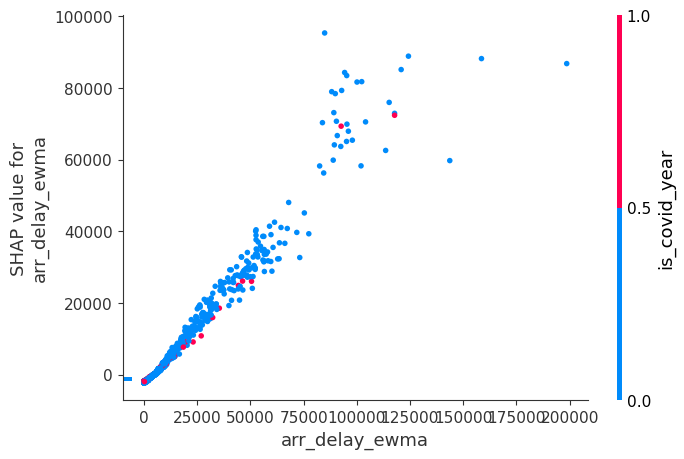

In [50]:
# ========== SHAP Dependence Plot with Interaction ==========
print("\n🔍 SHAP Dependence Plot (with auto-detected interaction):")
shap.dependence_plot("arr_delay_ewma", shap_values, X_sample)

# Now Training the Model on the whole dataset 

In [51]:
# train LGBM regressor on the entire training set
lgb_final_model = LGBMRegressor(random_state=42)
lgb_final_model.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4113
[LightGBM] [Info] Number of data points in the train set: 156178, number of used features: 20
[LightGBM] [Info] Start training from score 3773.791392


LGBMRegressor(random_state=42)

In [52]:
# use test_df to test the model and print MAE
X_test = test_df.drop(columns=drop_cols + [target])
y_test = test_df[target]
lgb_test_preds = lgb_final_model.predict(X_test)
lgb_test_mae = mean_absolute_error(y_test, lgb_test_preds)
print(f"\n📈 LightGBM Test MAE: {lgb_test_mae:.2f}")


📈 LightGBM Test MAE: 1542.26


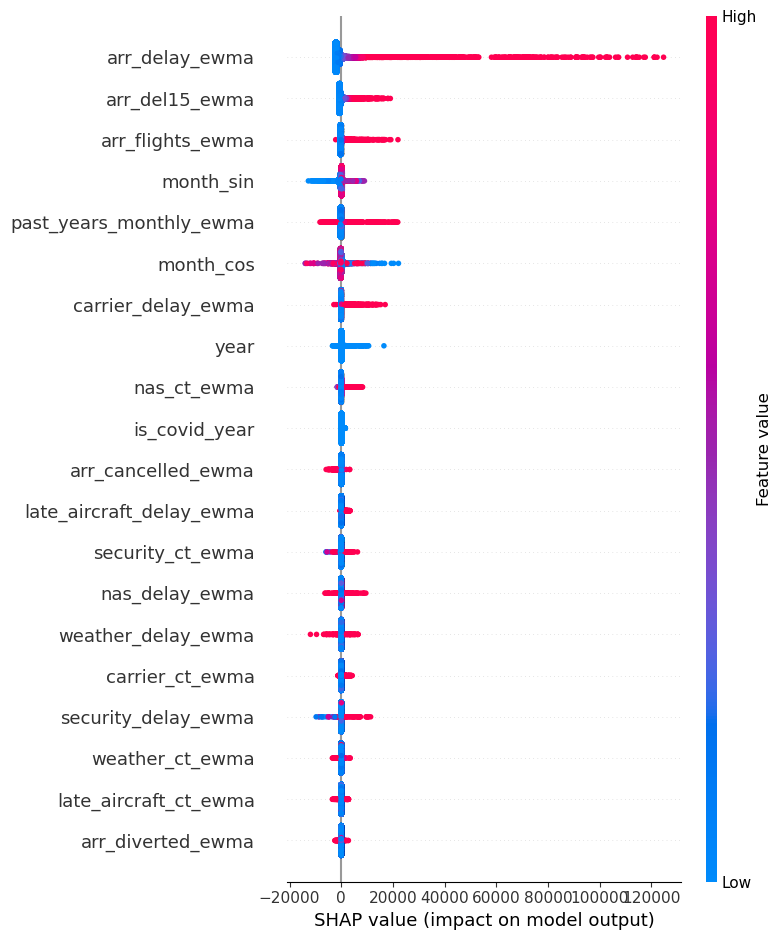

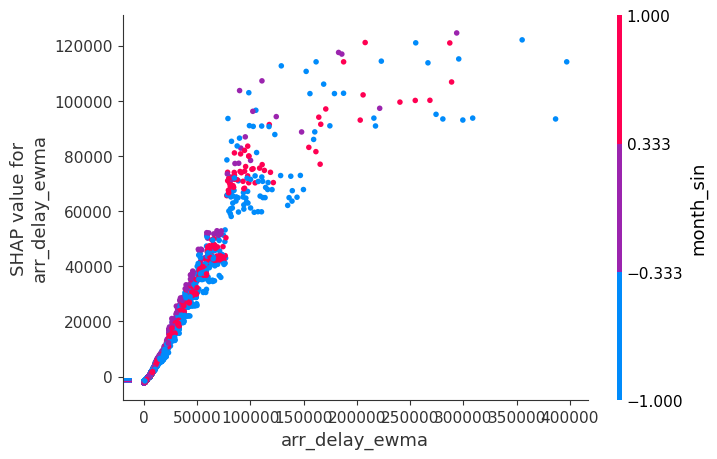

In [53]:
# again perform SHAP analysis on the final model
explainer_final = shap.TreeExplainer(lgb_final_model)
shap_values_final = explainer_final.shap_values(X_test)
# SHAP summary plot for the final model
shap.summary_plot(shap_values_final, X_test, plot_type="dot")
# SHAP dependence plot for the final model
shap.dependence_plot("arr_delay_ewma", shap_values_final, X_test)
# SHAP waterfall plot for the final model
example_shap_values_final = shap.Explanation(values=shap_values_final[0], base_values=explainer_final.expected_value,
                                               data=X_test.iloc[0], feature_names=X_test.columns)

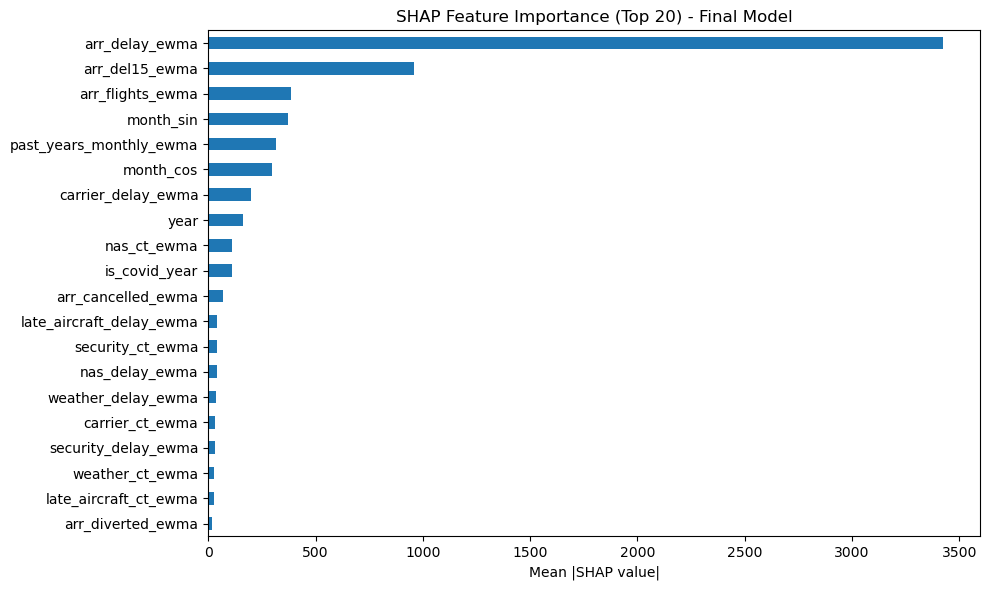

In [54]:
# plot feature importance for the final model
mean_shap_final_df = pd.Series(np.abs(shap_values_final).mean(axis=0), index=X_test.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
mean_shap_final_df.head(20).plot(kind='barh')
plt.title("SHAP Feature Importance (Top 20) - Final Model")
plt.xlabel("Mean |SHAP value|")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [55]:
# add the test prediction to the test_df as predicted_arr_delay
test_df['predicted_arr_delay'] = lgb_test_preds


In [56]:
test_df

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,security_ct_ewma,late_aircraft_ct_ewma,carrier_delay_ewma,weather_delay_ewma,nas_delay_ewma,security_delay_ewma,late_aircraft_delay_ewma,past_years_monthly_ewma,is_covid_year,predicted_arr_delay
4,2023,1,9E,ABE,14.0,1.0,0.00,1.00,0.00,0.00,...,1.296875e-02,0.752849,229.284482,9.285838,77.758731,3.906250e-01,33.093488,381.250000,0,442.254977
23,2023,5,9E,ABE,68.0,0.0,0.00,0.00,0.00,0.00,...,6.484375e-03,0.376424,114.642241,328.142919,39.379365,1.953125e-01,16.546744,298.875000,0,464.761239
29,2023,6,9E,ABE,86.0,15.0,6.03,2.23,4.12,0.00,...,3.242187e-03,0.188212,57.321121,164.071459,19.689683,9.765625e-02,8.273372,1040.812500,0,602.573777
34,2023,7,9E,ABE,86.0,9.0,6.00,0.00,1.00,0.00,...,1.621094e-03,1.409106,167.660560,152.535730,85.344841,4.882812e-02,115.636686,335.250000,0,683.797752
38,2023,8,9E,ABE,89.0,13.0,2.25,1.60,3.16,0.00,...,8.105469e-04,1.704553,198.830280,76.267865,68.672421,2.441406e-02,104.318343,812.250000,0,563.714570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178706,2023,12,OO,YUM,121.0,15.0,7.27,1.67,3.15,0.00,...,1.116364e-22,2.465354,514.831610,366.586178,439.833534,6.968172e-21,173.580895,1255.609375,0,1857.934130
178710,2023,1,YV,YUM,52.0,3.0,1.00,0.00,0.00,0.00,...,4.577637e-07,1.987311,53.475058,0.070000,9.220415,4.577637e-05,159.945000,889.250000,0,367.854565
178713,2023,2,YV,YUM,30.0,8.0,1.33,0.00,2.67,0.00,...,2.288818e-07,1.993655,102.237529,0.035000,4.610207,2.288818e-05,195.472500,734.500000,0,407.020223
178717,2023,3,YV,YUM,31.0,10.0,0.70,0.00,0.86,0.19,...,1.144409e-07,2.996828,68.118765,0.017500,29.805104,1.144409e-05,497.236250,625.250000,0,481.675057


In [58]:
test_df[['arr_delay', 'predicted_arr_delay']]

,arr_delay,predicted_arr_delay
4,648.0,442.254977
23,0.0,464.761239
29,793.0,602.573777
34,375.0,683.797752
38,1375.0,563.714570
...,...,...
178706,1989.0,1857.934130
178710,382.0,367.854565
178713,888.0,407.020223
178717,769.0,481.675057


In [57]:
# print the R^2 score of the final model on the test set
from sklearn.metrics import r2_score
r2_final = r2_score(y_test, lgb_test_preds)
print(f"\n📊 LightGBM Test R² Score: {r2_final:.2f}")


📊 LightGBM Test R² Score: 0.88


In [59]:
# store the final model using pickle
import pickle
lgb_final_model = LGBMRegressor(random_state=42)
# save 
with open('../models/lgb_final_model.pkl', 'wb') as f:
    pickle.dump(lgb_final_model, f)
# store the test_df with predictions
test_df.to_csv('../data/test_predictions.csv', index=False)

In [62]:
data_2022=train_val_df[train_val_df['year']==2022]

In [63]:
data_2022

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,nas_ct_ewma,security_ct_ewma,late_aircraft_ct_ewma,carrier_delay_ewma,weather_delay_ewma,nas_delay_ewma,security_delay_ewma,late_aircraft_delay_ewma,past_years_monthly_ewma,is_covid_year
3,2022,1,9E,ABE,119.0,14.0,5.43,1.00,6.83,0.00,...,3.525937,0.000000e+00,2.299265,258.827408,2.174503,96.235067,0.000000,106.932992,210.500,0
8,2022,2,9E,ABE,112.0,7.0,3.99,0.47,2.54,0.00,...,5.177968,0.000000e+00,1.524632,264.413704,45.587252,136.117533,0.000000,61.966496,628.875,0
13,2022,3,9E,ABE,135.0,12.0,4.21,1.93,3.25,0.83,...,3.858984,0.000000e+00,0.762316,226.206852,30.293626,107.558767,0.000000,30.983248,234.125,0
17,2022,4,9E,ABE,132.0,6.0,2.00,0.00,3.82,0.00,...,3.554492,4.150000e-01,1.271158,175.103426,105.146813,107.279383,12.500000,53.991624,403.000,0
21,2022,5,9E,ABE,136.0,7.0,5.95,0.00,0.05,0.00,...,3.687246,2.075000e-01,0.725579,116.551713,52.573406,104.139692,6.250000,32.495812,342.750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156160,2022,6,YV,YUM,1.0,0.0,0.00,0.00,0.00,0.00,...,0.718715,1.464844e-05,2.553940,103.201859,2.239998,23.053270,0.001465,194.239988,270.500,0
156165,2022,9,YV,YUM,8.0,0.0,0.00,0.00,0.00,0.00,...,0.359358,7.324219e-06,1.276970,51.600929,1.119999,11.526635,0.000732,97.119994,197.500,0
156169,2022,10,YV,YUM,26.0,6.0,2.17,0.00,0.41,0.00,...,0.179679,3.662109e-06,0.638485,25.800465,0.560000,5.763318,0.000366,48.559997,306.500,0
156173,2022,11,YV,YUM,2.0,0.0,0.00,0.00,0.00,0.00,...,0.294839,1.831055e-06,2.029243,147.900232,0.280000,28.881659,0.000183,189.779999,551.000,0


In [64]:
# add a new column called controllable delay which is the sum of carrier_delay, nas_delay, security_delay, late_aircraft_delay
data_2022['controllable_delay'] = (data_2022['carrier_delay'] + 
                                    data_2022['late_aircraft_delay'])
# add a new columns called controllable_ratio which is the controllable delay divided by the arr_delay
data_2022['controllable_ratio'] = data_2022['controllable_delay'] / (data_2022['arr_delay'] + 1e-6)


/var/folders/7w/qs77cz_11630n9gydm61vjpc0000gn/T/ipykernel_68344/3843844554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2022['controllable_delay'] = (data_2022['carrier_delay'] +
/var/folders/7w/qs77cz_11630n9gydm61vjpc0000gn/T/ipykernel_68344/3843844554.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2022['controllable_ratio'] = data_2022['controllable_delay'] / (data_2022['arr_delay'] + 1e-6)


In [65]:
data_2022

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,late_aircraft_ct_ewma,carrier_delay_ewma,weather_delay_ewma,nas_delay_ewma,security_delay_ewma,late_aircraft_delay_ewma,past_years_monthly_ewma,is_covid_year,controllable_delay,controllable_ratio
3,2022,1,9E,ABE,119.0,14.0,5.43,1.00,6.83,0.00,...,2.299265,258.827408,2.174503,96.235067,0.000000,106.932992,210.500,0,287.0,0.519928
8,2022,2,9E,ABE,112.0,7.0,3.99,0.47,2.54,0.00,...,1.524632,264.413704,45.587252,136.117533,0.000000,61.966496,628.875,0,188.0,0.666667
13,2022,3,9E,ABE,135.0,12.0,4.21,1.93,3.25,0.83,...,0.762316,226.206852,30.293626,107.558767,0.000000,30.983248,234.125,0,201.0,0.391813
17,2022,4,9E,ABE,132.0,6.0,2.00,0.00,3.82,0.00,...,1.271158,175.103426,105.146813,107.279383,12.500000,53.991624,403.000,0,69.0,0.405882
21,2022,5,9E,ABE,136.0,7.0,5.95,0.00,0.05,0.00,...,0.725579,116.551713,52.573406,104.139692,6.250000,32.495812,342.750,0,251.0,0.984314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156160,2022,6,YV,YUM,1.0,0.0,0.00,0.00,0.00,0.00,...,2.553940,103.201859,2.239998,23.053270,0.001465,194.239988,270.500,0,0.0,0.000000
156165,2022,9,YV,YUM,8.0,0.0,0.00,0.00,0.00,0.00,...,1.276970,51.600929,1.119999,11.526635,0.000732,97.119994,197.500,0,0.0,0.000000
156169,2022,10,YV,YUM,26.0,6.0,2.17,0.00,0.41,0.00,...,0.638485,25.800465,0.560000,5.763318,0.000366,48.559997,306.500,0,601.0,0.920368
156173,2022,11,YV,YUM,2.0,0.0,0.00,0.00,0.00,0.00,...,2.029243,147.900232,0.280000,28.881659,0.000183,189.779999,551.000,0,0.0,0.000000


In [66]:
# join this controllable_ratio to the test_df based on month,carrier,airport
test_df = test_df.merge(data_2022[['month', 'carrier', 'airport', 'controllable_ratio']],
                        on=['month', 'carrier', 'airport'], how='left')

In [67]:
test_df

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,late_aircraft_ct_ewma,carrier_delay_ewma,weather_delay_ewma,nas_delay_ewma,security_delay_ewma,late_aircraft_delay_ewma,past_years_monthly_ewma,is_covid_year,predicted_arr_delay,controllable_ratio
0,2023,1,9E,ABE,14.0,1.0,0.00,1.00,0.00,0.00,...,0.752849,229.284482,9.285838,77.758731,3.906250e-01,33.093488,381.250000,0,442.254977,0.519928
1,2023,5,9E,ABE,68.0,0.0,0.00,0.00,0.00,0.00,...,0.376424,114.642241,328.142919,39.379365,1.953125e-01,16.546744,298.875000,0,464.761239,0.984314
2,2023,6,9E,ABE,86.0,15.0,6.03,2.23,4.12,0.00,...,0.188212,57.321121,164.071459,19.689683,9.765625e-02,8.273372,1040.812500,0,602.573777,0.932005
3,2023,7,9E,ABE,86.0,9.0,6.00,0.00,1.00,0.00,...,1.409106,167.660560,152.535730,85.344841,4.882812e-02,115.636686,335.250000,0,683.797752,0.759690
4,2023,8,9E,ABE,89.0,13.0,2.25,1.60,3.16,0.00,...,1.704553,198.830280,76.267865,68.672421,2.441406e-02,104.318343,812.250000,0,563.714570,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22564,2023,12,OO,YUM,121.0,15.0,7.27,1.67,3.15,0.00,...,2.465354,514.831610,366.586178,439.833534,6.968172e-21,173.580895,1255.609375,0,1857.934130,0.644343
22565,2023,1,YV,YUM,52.0,3.0,1.00,0.00,0.00,0.00,...,1.987311,53.475058,0.070000,9.220415,4.577637e-05,159.945000,889.250000,0,367.854565,0.959962
22566,2023,2,YV,YUM,30.0,8.0,1.33,0.00,2.67,0.00,...,1.993655,102.237529,0.035000,4.610207,2.288818e-05,195.472500,734.500000,0,407.020223,0.907654
22567,2023,3,YV,YUM,31.0,10.0,0.70,0.00,0.86,0.19,...,2.996828,68.118765,0.017500,29.805104,1.144409e-05,497.236250,625.250000,0,481.675057,0.789773


In [68]:
# rename the controllable_ratio column to controllable_ratio_2022
test_df.rename(columns={'controllable_ratio': 'controllable_ratio_2022'}, inplace=True)

In [69]:
test_df

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,late_aircraft_ct_ewma,carrier_delay_ewma,weather_delay_ewma,nas_delay_ewma,security_delay_ewma,late_aircraft_delay_ewma,past_years_monthly_ewma,is_covid_year,predicted_arr_delay,controllable_ratio_2022
0,2023,1,9E,ABE,14.0,1.0,0.00,1.00,0.00,0.00,...,0.752849,229.284482,9.285838,77.758731,3.906250e-01,33.093488,381.250000,0,442.254977,0.519928
1,2023,5,9E,ABE,68.0,0.0,0.00,0.00,0.00,0.00,...,0.376424,114.642241,328.142919,39.379365,1.953125e-01,16.546744,298.875000,0,464.761239,0.984314
2,2023,6,9E,ABE,86.0,15.0,6.03,2.23,4.12,0.00,...,0.188212,57.321121,164.071459,19.689683,9.765625e-02,8.273372,1040.812500,0,602.573777,0.932005
3,2023,7,9E,ABE,86.0,9.0,6.00,0.00,1.00,0.00,...,1.409106,167.660560,152.535730,85.344841,4.882812e-02,115.636686,335.250000,0,683.797752,0.759690
4,2023,8,9E,ABE,89.0,13.0,2.25,1.60,3.16,0.00,...,1.704553,198.830280,76.267865,68.672421,2.441406e-02,104.318343,812.250000,0,563.714570,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22564,2023,12,OO,YUM,121.0,15.0,7.27,1.67,3.15,0.00,...,2.465354,514.831610,366.586178,439.833534,6.968172e-21,173.580895,1255.609375,0,1857.934130,0.644343
22565,2023,1,YV,YUM,52.0,3.0,1.00,0.00,0.00,0.00,...,1.987311,53.475058,0.070000,9.220415,4.577637e-05,159.945000,889.250000,0,367.854565,0.959962
22566,2023,2,YV,YUM,30.0,8.0,1.33,0.00,2.67,0.00,...,1.993655,102.237529,0.035000,4.610207,2.288818e-05,195.472500,734.500000,0,407.020223,0.907654
22567,2023,3,YV,YUM,31.0,10.0,0.70,0.00,0.86,0.19,...,2.996828,68.118765,0.017500,29.805104,1.144409e-05,497.236250,625.250000,0,481.675057,0.789773


In [70]:
# create a new columns called predicted_controllable_delay which is the predicted_arr_delay multiplied by the controllable_ratio_2022
test_df['predicted_controllable_delay'] = test_df['predicted_arr_delay'] * test_df['controllable_ratio_2022']
test_df

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,carrier_delay_ewma,weather_delay_ewma,nas_delay_ewma,security_delay_ewma,late_aircraft_delay_ewma,past_years_monthly_ewma,is_covid_year,predicted_arr_delay,controllable_ratio_2022,predicted_controllable_delay
0,2023,1,9E,ABE,14.0,1.0,0.00,1.00,0.00,0.00,...,229.284482,9.285838,77.758731,3.906250e-01,33.093488,381.250000,0,442.254977,0.519928,229.940540
1,2023,5,9E,ABE,68.0,0.0,0.00,0.00,0.00,0.00,...,114.642241,328.142919,39.379365,1.953125e-01,16.546744,298.875000,0,464.761239,0.984314,457.470865
2,2023,6,9E,ABE,86.0,15.0,6.03,2.23,4.12,0.00,...,57.321121,164.071459,19.689683,9.765625e-02,8.273372,1040.812500,0,602.573777,0.932005,561.601585
3,2023,7,9E,ABE,86.0,9.0,6.00,0.00,1.00,0.00,...,167.660560,152.535730,85.344841,4.882812e-02,115.636686,335.250000,0,683.797752,0.759690,519.474257
4,2023,8,9E,ABE,89.0,13.0,2.25,1.60,3.16,0.00,...,198.830280,76.267865,68.672421,2.441406e-02,104.318343,812.250000,0,563.714570,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22564,2023,12,OO,YUM,121.0,15.0,7.27,1.67,3.15,0.00,...,514.831610,366.586178,439.833534,6.968172e-21,173.580895,1255.609375,0,1857.934130,0.644343,1197.147413
22565,2023,1,YV,YUM,52.0,3.0,1.00,0.00,0.00,0.00,...,53.475058,0.070000,9.220415,4.577637e-05,159.945000,889.250000,0,367.854565,0.959962,353.126355
22566,2023,2,YV,YUM,30.0,8.0,1.33,0.00,2.67,0.00,...,102.237529,0.035000,4.610207,2.288818e-05,195.472500,734.500000,0,407.020223,0.907654,369.433497
22567,2023,3,YV,YUM,31.0,10.0,0.70,0.00,0.86,0.19,...,68.118765,0.017500,29.805104,1.144409e-05,497.236250,625.250000,0,481.675057,0.789773,380.413821


In [71]:
test_df.to_csv('../data/test_predictions_with_controllable_delay.csv', index=False)